In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import math
from microbiomeGPT import utils, embeddings
from microbiomeGPT.model import MicrobiomeTransformer, MicrobiomeTransformerClassification, MicrobiomeTransformerRegression
from gemelli.preprocessing import matrix_rclr # can use np.log1p as well. 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

In [2]:
metadata = pd.read_csv('../data/sampleMetadata.csv', index_col='sample_id')
metadata = metadata.loc[(metadata.body_site=='stool')&(metadata.disease=='healthy')]#metadata.loc[(metadata.age.notna())&(metadata.body_site=='stool')&(metadata.disease=='healthy')]
# metadata = metadata.loc[metadata.study_name!='BackhedF_2015']
metadata = metadata.loc[metadata.number_reads>1000000]
metadata = metadata.drop_duplicates(subset='subject_id', keep='first')

/var/folders/y9/wgj9mj_1555fbmw9d5qfq36m0000gn/T/ipykernel_60480/1066728264.py:1: DtypeWarning: Columns (21,22,25,28,29,30,32,33,35,38,51,52,53,54,55,56,57,58,63,64,65,67,68,69,74,75,76,80,90,91,92,93,96,104,105,108,109,111,112,116,117,118,119,120,121,126,128,129,134) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('../data/sampleMetadata.csv', index_col='sample_id')


In [3]:
# Count the occurrences of each study_name
study_counts = metadata.study_name.value_counts()

# Keep only the rows where study_name occurs more than once
metadata = metadata[metadata['study_name'].isin(study_counts[study_counts > 1].index)]

In [4]:
raw_df = pd.read_csv('../data/relative_abundance.csv', index_col=0)
df = raw_df.drop_duplicates(subset='subject_id', keep='first').copy()
df = pd.DataFrame(matrix_rclr(df.iloc[:,3:].fillna(0)), index=df.index, columns=df.iloc[:,3:].columns).fillna(0)#np.log1p(df.iloc[:,3:].fillna(0))
df = df.loc[df.index.isin(metadata.index)]
print(df.shape)
# Calculate the threshold: 25% of the number of rows
threshold = 0#len(df) #* 0.25

# Filter columns that have at least the threshold number of non-zero values
df = df.loc[:, (df != 0).sum(axis=0) >= threshold]
print(df.shape)
df = df.loc[(df != 0).any(axis=1)]
print(df.shape)

all_zero_columns = (df == 0).all(axis=0)
num_all_zero_columns = all_zero_columns.sum()

print(f'Number of columns with all zeros: {num_all_zero_columns}')
df = df.loc[:, ~all_zero_columns]
n_features = df.shape[1]

/Users/tylermyers/anaconda3/envs/transformers/lib/python3.10/site-packages/gemelli/preprocessing.py:425: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


(8437, 2047)
(8437, 2047)
(8435, 2047)
Number of columns with all zeros: 715


In [43]:
df.head()

,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Escherichia|s__Escherichia_coli,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_bifidum,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_longum,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_faecalis,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Ruminococcus_gnavus,k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Veillonella|s__Veillonella_atypica,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_breve,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Klebsiella|s__Klebsiella_pneumoniae,k__Bacteria|p__Firmicutes|c__Negativicutes|o__Veillonellales|f__Veillonellaceae|g__Veillonella|s__Veillonella_parvula,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_MSTE9,...,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae|g__Desulfotomaculum|s__Desulfotomaculum_ruminis,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobacterium|s__Methanobacterium_sp_MB1,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Weissella|s__Weissella_hellenica,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_vitulinus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_crustorum,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Alkaliphilus|s__Alkaliphilus_oremlandii,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Paenibacillaceae|g__Paenibacillus|s__Paenibacillus_polysaccharolyticus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_frumenti,k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Oligella|s__Oligella_ureolytica,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Paenibacillaceae|g__Paenibacillus|s__Paenibacillus_sp_7884_2
SampleID,,,,,,,,,,,,,,,,,,,,,
MV_FEI1_t1Q14,6.101332,4.800567,4.070962,3.905114,2.960023,2.390407,2.077920,2.057109,2.041926,1.152255,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MV_FEI2_t1Q14,0.000000,4.957762,7.334962,0.087614,0.000000,-4.034489,0.000000,4.753636,-0.115645,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MV_FEI3_t1Q14,7.232309,1.184810,2.081977,4.791894,1.311962,-1.543540,1.188863,0.000000,2.774630,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MV_FEI4_t1Q14,4.317653,0.000000,0.000000,0.000000,0.000000,0.000000,2.768969,0.000000,1.744944,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MV_FEI4_t2Q15,1.757760,5.642177,0.000000,1.059964,0.000000,3.475426,5.017791,-2.748121,3.932232,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
metadata.head()

,study_name,subject_id,body_site,antibiotics_current_use,study_condition,disease,age,infant_age,age_category,gender,...,hla_dqa11,hla_drb11,zigosity,brinkman_index,alcohol_numeric,breastfeeding_duration,formula_first_day,ALT,eGFR,health_status
SampleID,,,,,,,,,,,,,,,,,,,,,
MV_FEI1_t1Q14,AsnicarF_2017,MV_FEI1,stool,NaN,control,healthy,0.0,90.0,newborn,female,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,healthy
MV_FEI2_t1Q14,AsnicarF_2017,MV_FEI2,stool,NaN,control,healthy,0.0,90.0,newborn,male,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,healthy
MV_FEI3_t1Q14,AsnicarF_2017,MV_FEI3,stool,NaN,control,healthy,0.0,90.0,newborn,male,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,healthy
MV_FEI4_t1Q14,AsnicarF_2017,MV_FEI4,stool,NaN,control,healthy,1.0,NaN,child,male,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,healthy
MV_FEI4_t2Q15,AsnicarF_2017,MV_FEI4,stool,NaN,control,healthy,1.0,NaN,child,male,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,healthy


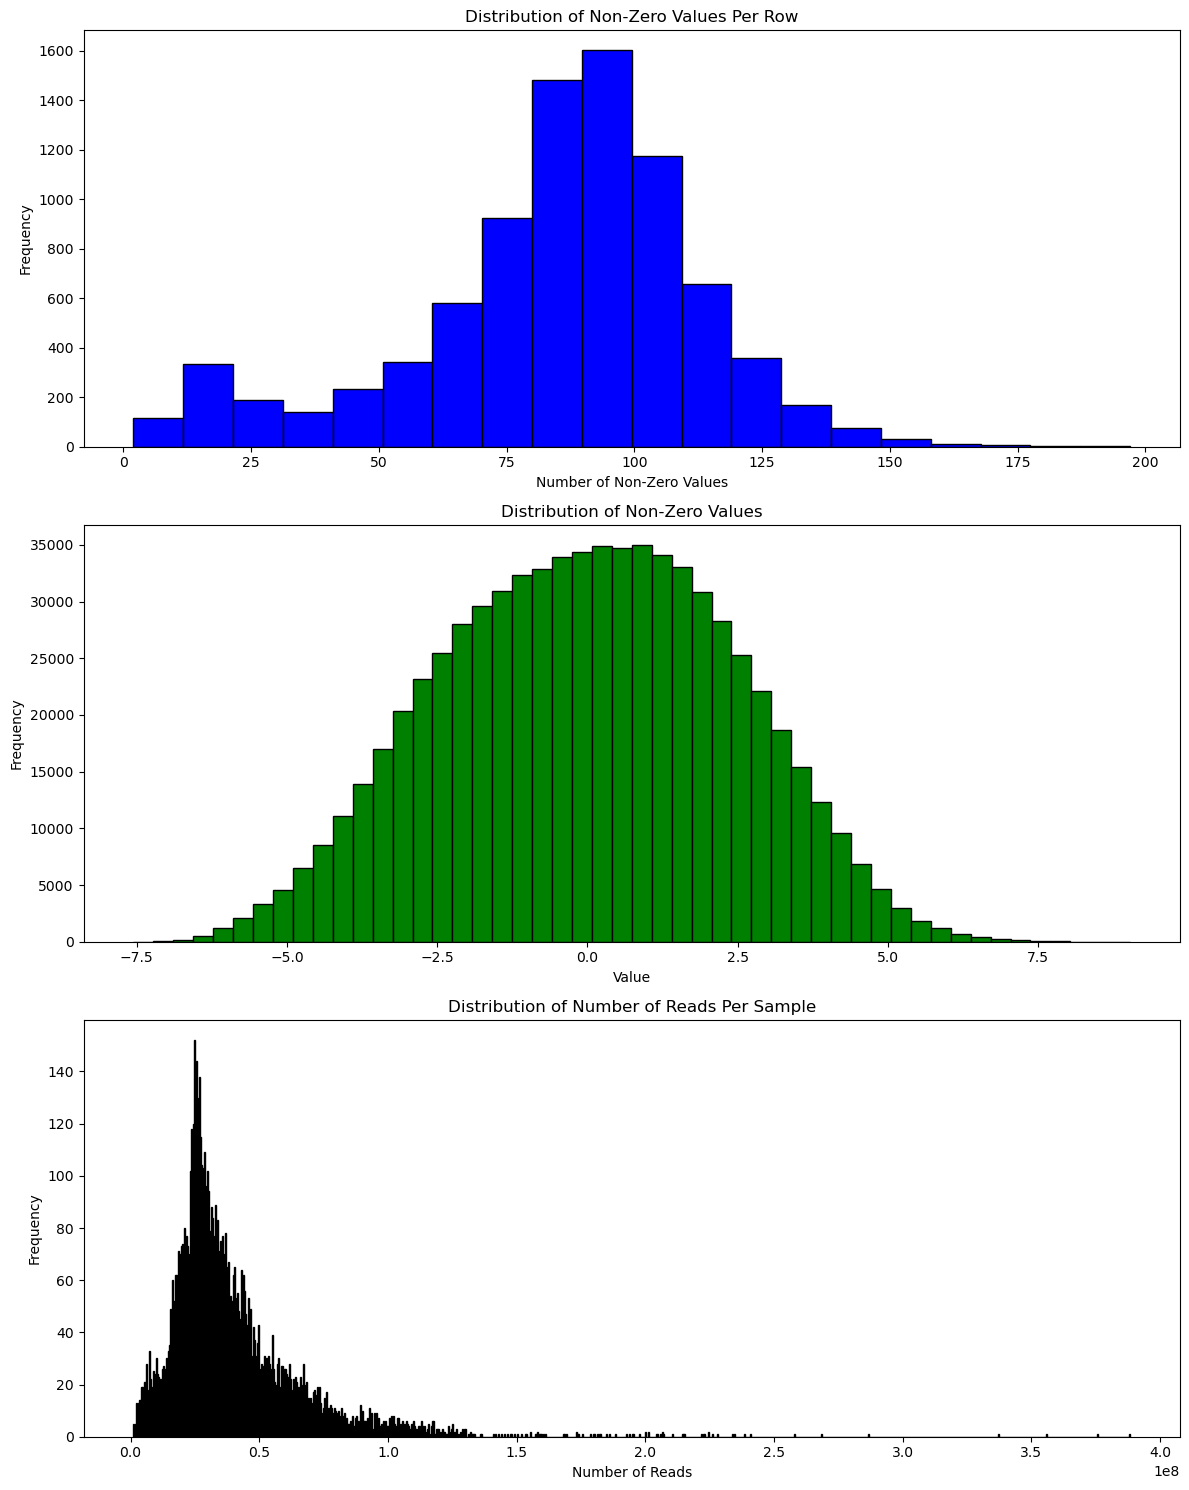

In [5]:
non_zero_counts_per_row = (df != 0).sum(axis=1)
non_zero_values = df.values[df.values != 0]

# Create a figure with three subplots arranged vertically
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))
fig.tight_layout(pad=3.0)  # Add padding between subplots

# First subplot: Non-zero values per row
ax1.hist(non_zero_counts_per_row, bins=20, color='blue', edgecolor='black')
ax1.set_title('Distribution of Non-Zero Values Per Row')
ax1.set_xlabel('Number of Non-Zero Values')
ax1.set_ylabel('Frequency')

# Second subplot: Distribution of non-zero values
ax2.hist(non_zero_values, bins=50, color='green', edgecolor='black')
ax2.set_title('Distribution of Non-Zero Values')
ax2.set_xlabel('Value')
ax2.set_ylabel('Frequency')

# Third subplot: Number of reads per sample
ax3.hist(metadata.number_reads, bins=1000, color='blue', edgecolor='black')
ax3.set_title('Distribution of Number of Reads Per Sample')
ax3.set_xlabel('Number of Reads')
ax3.set_ylabel('Frequency')

# Adjust the layout to prevent overlapping
plt.tight_layout()
plt.show()

In [6]:
metadata = metadata.loc[df.index]
metadata = metadata[~metadata.index.duplicated(keep='first')]
df = df[~df.index.duplicated(keep='first')]
df = df.loc[df.index.isin(metadata.index)]
metadata = metadata.loc[metadata.index.isin(df.index)]

### Train your model

In [7]:
# Main execution
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')

# Create vocabulary
vocab = ['<PAD>', '<START>', '<END>'] + raw_df.columns.tolist()
vocab_size = len(vocab)
taxa_to_idx = {taxa: idx for idx, taxa in enumerate(vocab)}
stratify_column = metadata.study_name.astype(str)

# Prepare data
max_features = 128  # Set this to your desired maximum number of features
dataset = utils.MicrobiomeDataset(df, taxa_to_idx, max_features=max_features)
train_data, test_data = train_test_split(dataset, test_size=0.1, random_state=42, stratify=stratify_column) #consider stratify by study...
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=utils.collate_fn)
test_loader = DataLoader(test_data, batch_size=32, collate_fn=utils.collate_fn)

# Initialize model
model = MicrobiomeTransformer(vocab_size, d_model=2048, nhead=8, num_encoder_layers=1, max_features=max_features, taxa_to_idx=taxa_to_idx).to(device)

# Train the model
utils.train(model, train_loader, test_loader, epochs=100, lr=0.00005, device=device)

/Users/tylermyers/anaconda3/envs/transformers/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1, Train Loss: 287.8317, Val Loss: 260.6506
Epoch 2, Train Loss: 257.1920, Val Loss: 241.6609
Epoch 3, Train Loss: 240.7873, Val Loss: 226.9087
Epoch 4, Train Loss: 227.2033, Val Loss: 210.4031
Epoch 5, Train Loss: 212.1475, Val Loss: 193.9177
Epoch 6, Train Loss: 198.2266, Val Loss: 178.5608
Epoch 7, Train Loss: 187.3171, Val Loss: 168.2344
Epoch 8, Train Loss: 179.9190, Val Loss: 161.4705
Epoch 9, Train Loss: 175.5657, Val Loss: 158.3629
Epoch 10, Train Loss: 173.7298, Val Loss: 157.4361
Epoch 11, Train Loss: 167.0153, Val Loss: 134.6402
Epoch 12, Train Loss: 142.7991, Val Loss: 108.0538
Epoch 13, Train Loss: 119.9739, Val Loss: 85.8167
Epoch 14, Train Loss: 100.6280, Val Loss: 69.7512
Epoch 15, Train Loss: 84.4757, Val Loss: 57.4590
Epoch 16, Train Loss: 71.4277, Val Loss: 47.8932
Epoch 17, Train Loss: 61.1947, Val Loss: 40.7229
Epoch 18, Train Loss: 53.0169, Val Loss: 35.1988
Epoch 19, Train Loss: 46.7037, Val Loss: 31.1717
Epoch 20, Train Loss: 41.4927, Val Loss: 27.9378
Epo

In [36]:
import gc
torch.mps.empty_cache()
gc.collect()

83267

### Explore Embeddings and Model Training

In [9]:
# reload all the data but we needed to not have the baby/mother study included. 
metadata = pd.read_csv('../data/sampleMetadata.csv', index_col='sample_id')
metadata.shape
raw_df = pd.read_csv('../data/relative_abundance.csv', index_col=0)
df = raw_df.copy()
df = pd.DataFrame(matrix_rclr(df.iloc[:,3:].fillna(0)), index=df.index, columns=df.iloc[:,3:].columns).fillna(0)#np.log1p(df.iloc[:,3:].fillna(0))
df = df.loc[df.index.isin(metadata.index)]

metadata = metadata.loc[df.index]
metadata = metadata[~metadata.index.duplicated(keep='first')]
df = df[~df.index.duplicated(keep='first')]
df = df.loc[df.index.isin(metadata.index)]
metadata = metadata.loc[metadata.index.isin(df.index)]
metadata['health_status'] = metadata['disease'].apply(lambda x: 'healthy' if x == 'healthy' else 'disease')

/var/folders/y9/wgj9mj_1555fbmw9d5qfq36m0000gn/T/ipykernel_60480/1176631639.py:2: DtypeWarning: Columns (21,22,25,28,29,30,32,33,35,38,51,52,53,54,55,56,57,58,63,64,65,67,68,69,74,75,76,80,90,91,92,93,96,104,105,108,109,111,112,116,117,118,119,120,121,126,128,129,134) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('../data/sampleMetadata.csv', index_col='sample_id')
/Users/tylermyers/anaconda3/envs/transformers/lib/python3.10/site-packages/gemelli/preprocessing.py:425: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


/Users/tylermyers/Desktop/CMI/dissertation/aim4_microbiomegpt/mgpt_for_code_rev/microbiomeGPT/embeddings.py:94: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


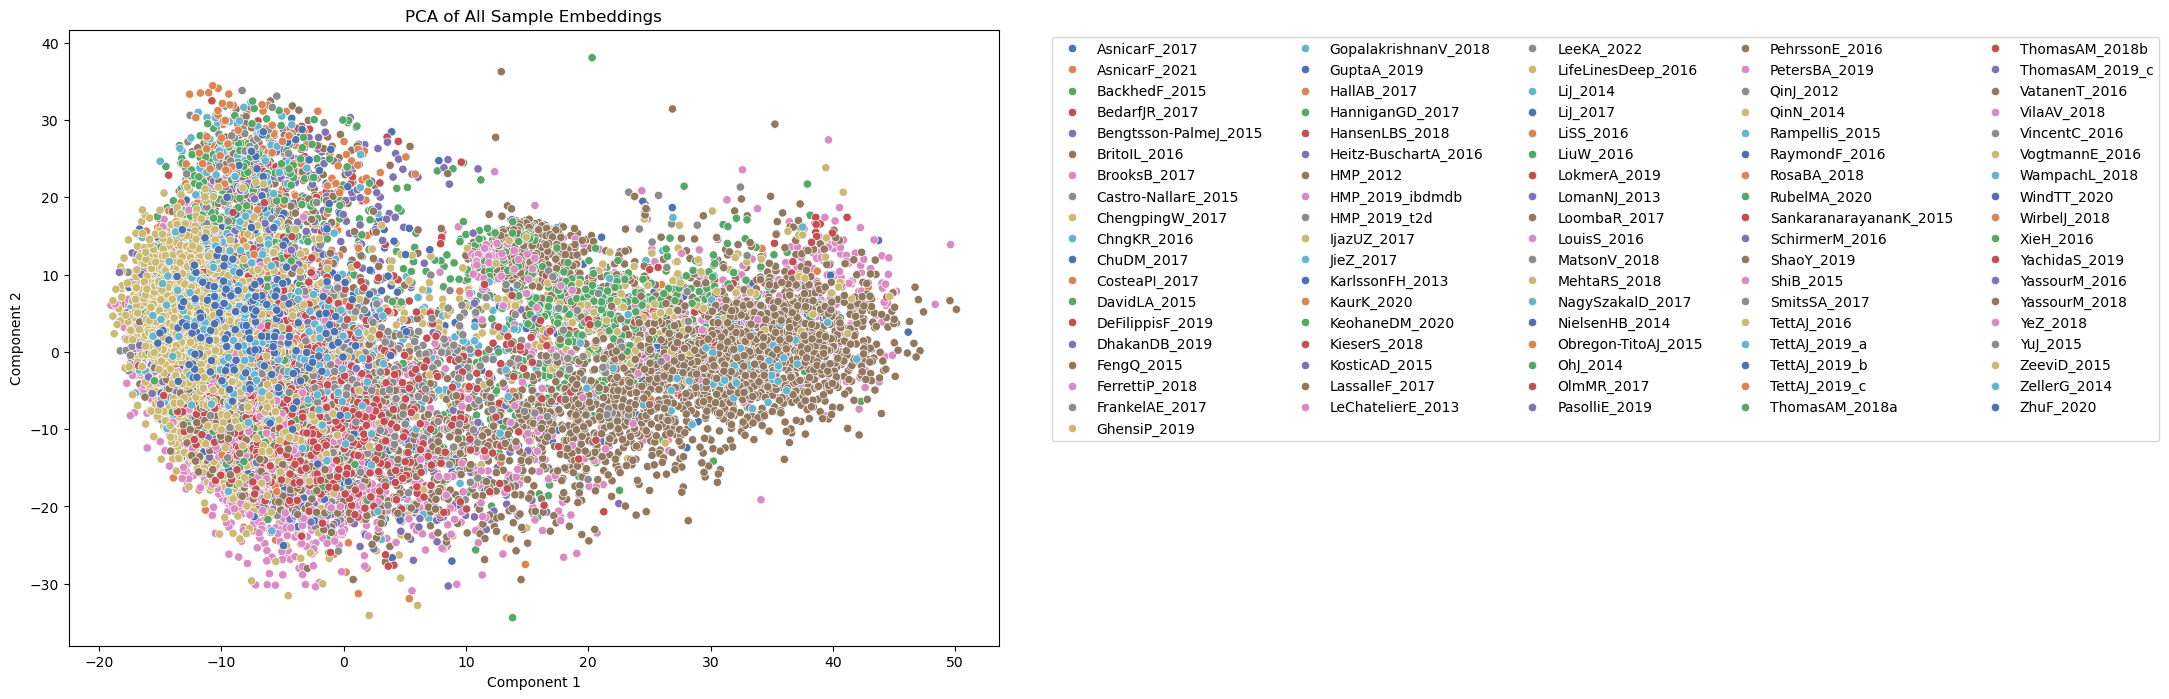

/Users/tylermyers/Desktop/CMI/dissertation/aim4_microbiomegpt/mgpt_for_code_rev/microbiomeGPT/embeddings.py:94: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


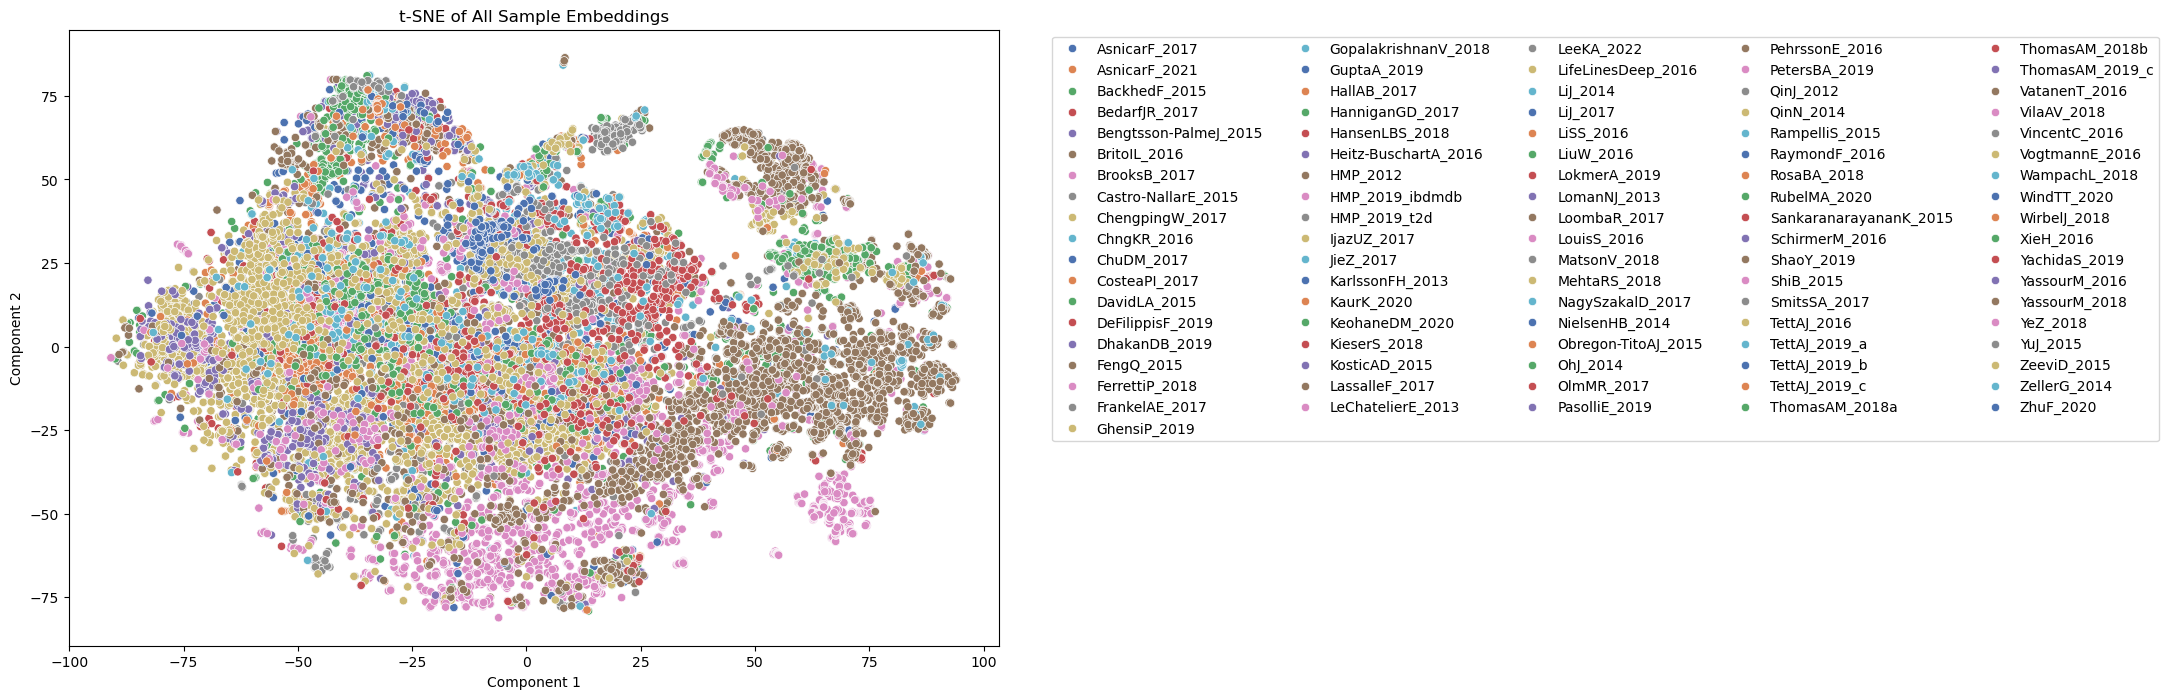

In [10]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Create the full dataset
full_dataset = utils.MicrobiomeDataset(df, taxa_to_idx, max_features=max_features)

# Create DataLoader for the full dataset
full_loader = DataLoader(full_dataset, batch_size=32, shuffle=False, collate_fn=utils.collate_fn)

# Extract embeddings for the full dataset
model.to(device)
all_embeddings = embeddings.get_embeddings(model, full_loader, device)

# Get corresponding study names for all samples
all_study_names = metadata['study_name'].tolist()

# Ensure the number of study names matches the number of embeddings
if len(all_study_names) != len(all_embeddings):
    print(f"Warning: Number of study names ({len(all_study_names)}) "
          f"does not match number of embeddings ({len(all_embeddings)}). "
          "Using available study names and truncating if necessary.")
    all_study_names = all_study_names[:len(all_embeddings)]

# Reduce dimensions
pca_embeddings = embeddings.reduce_dimensions(all_embeddings.numpy(), method='pca')
tsne_embeddings = embeddings.reduce_dimensions(all_embeddings.numpy(), method='tsne')

# Plot
embeddings.plot_embeddings(pca_embeddings, all_study_names, 'PCA of All Sample Embeddings')
embeddings.plot_embeddings(tsne_embeddings, all_study_names, 't-SNE of All Sample Embeddings')

Taxa Prediction Accuracy: 0.9943
Expression Prediction MSE: 0.0360


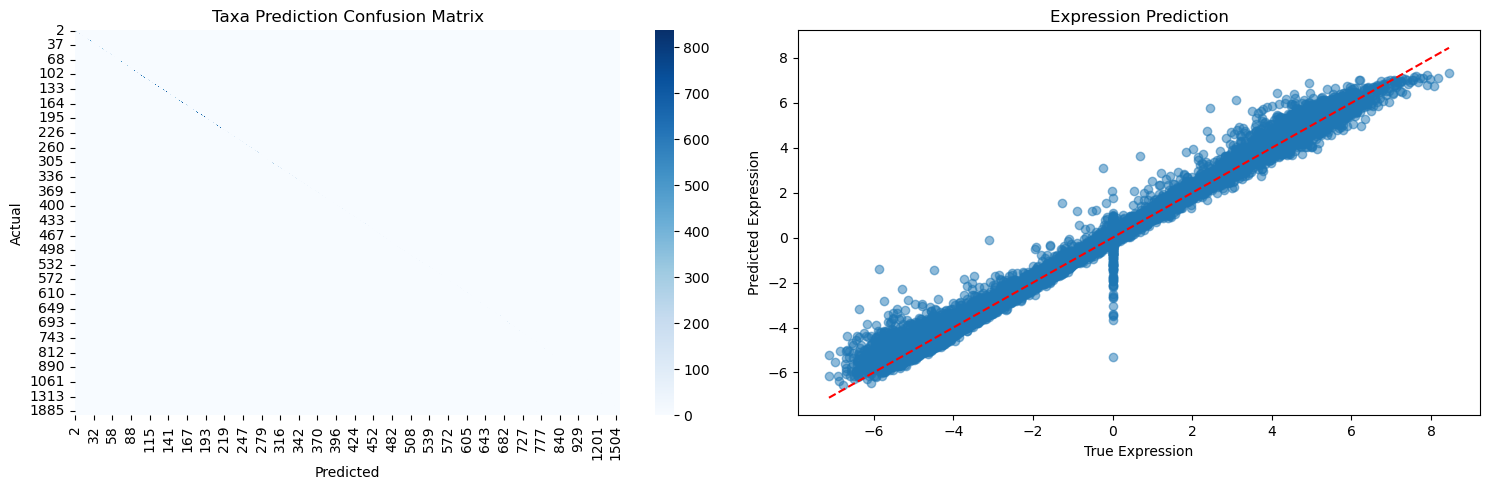

In [11]:
# Inspect predictions
model.load_state_dict(torch.load('best_model.pth'))
utils.inspect_predictions(model, test_loader, vocab, device)

### Training Regression

In [30]:
# Main execution for regression fine-tuning
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained model
pretrained_model = MicrobiomeTransformer(vocab_size, d_model=2048, nhead=8, num_encoder_layers=1, taxa_to_idx=taxa_to_idx).to(device)
pretrained_model.load_state_dict(torch.load('best_model.pth'))

# Create the regression model
regression_model = MicrobiomeTransformerRegression(pretrained_model, freeze_pretrained=True).to(device)

/Users/tylermyers/anaconda3/envs/transformers/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [31]:
df_regression = pd.DataFrame(matrix_rclr(raw_df.iloc[:,3:].fillna(0).copy()), index=raw_df.index, columns=raw_df.iloc[:,3:].columns).fillna(0)#np.log1p(raw_df.iloc[:,3:].fillna(0).copy())
df_regression = df_regression.loc[df_regression.index.isin(metadata.drop_duplicates(subset='subject_id', keep='first').index)]
df_regression['regression_target'] = metadata.loc[df_regression.index, 'age']
df_regression = df_regression.loc[df_regression.index.isin(metadata.loc[metadata.study_name == 'LifeLinesDeep_2016'].index)]
df_regression = df_regression.dropna()
print(df_regression.shape)

# Filter out classes with only one instance in the stratifying column
stratify_column = metadata.loc[df_regression.index].study_name
value_counts = stratify_column.value_counts()
valid_classes = value_counts[value_counts > 1].index

# Filter dataset and metadata to only include valid classes
valid_indices = stratify_column.isin(valid_classes)
metadata_filtered = metadata.loc[df_regression.index][valid_indices]
df_regression = df_regression.loc[valid_indices]

# Create vocabulary (same as before)
vocab = ['<PAD>', '<START>', '<END>'] + df_regression.drop(columns='regression_target').columns.tolist()
taxa_to_idx = {taxa: idx for idx, taxa in enumerate(vocab)}

# Prepare data
max_features = 128
dataset = utils.MicrobiomeRegressionDataset(df_regression, taxa_to_idx, 'regression_target', max_features=max_features)
train_data, test_data = train_test_split(dataset, test_size=0.1, random_state=42, stratify=metadata.loc[df_regression.index].study_name.astype(str))
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=utils.regression_collate_fn)
test_loader = DataLoader(test_data, batch_size=32, collate_fn=utils.regression_collate_fn)

# Train the regression model
utils.train_regression(regression_model, train_loader, test_loader, epochs=1000, lr=0.005, device=device)

/Users/tylermyers/anaconda3/envs/transformers/lib/python3.10/site-packages/gemelli/preprocessing.py:425: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


(1135, 2048)
Epoch 1, Train Loss: 2024.4933, Val Loss: 1915.2290
Epoch 2, Train Loss: 1924.7305, Val Loss: 1844.4401
Epoch 3, Train Loss: 1854.9512, Val Loss: 1777.6115
Epoch 4, Train Loss: 1792.6712, Val Loss: 1717.5938
Epoch 5, Train Loss: 1734.6317, Val Loss: 1667.4441
Epoch 6, Train Loss: 1693.3629, Val Loss: 1629.5499
Epoch 7, Train Loss: 1662.0804, Val Loss: 1602.9478
Epoch 8, Train Loss: 1641.0470, Val Loss: 1587.2888
Epoch 9, Train Loss: 1632.8287, Val Loss: 1580.0087
Epoch 10, Train Loss: 1617.4201, Val Loss: 1578.0903
Epoch 11, Train Loss: 1586.3714, Val Loss: 1501.7629
Epoch 12, Train Loss: 1504.9382, Val Loss: 1425.3076
Epoch 13, Train Loss: 1438.6264, Val Loss: 1351.4275
Epoch 14, Train Loss: 1357.7556, Val Loss: 1280.0981
Epoch 15, Train Loss: 1291.8306, Val Loss: 1212.1341
Epoch 16, Train Loss: 1221.7614, Val Loss: 1148.7343
Epoch 17, Train Loss: 1162.8169, Val Loss: 1089.3980
Epoch 18, Train Loss: 1112.2343, Val Loss: 1036.6160
Epoch 19, Train Loss: 1055.4634, Val Loss:

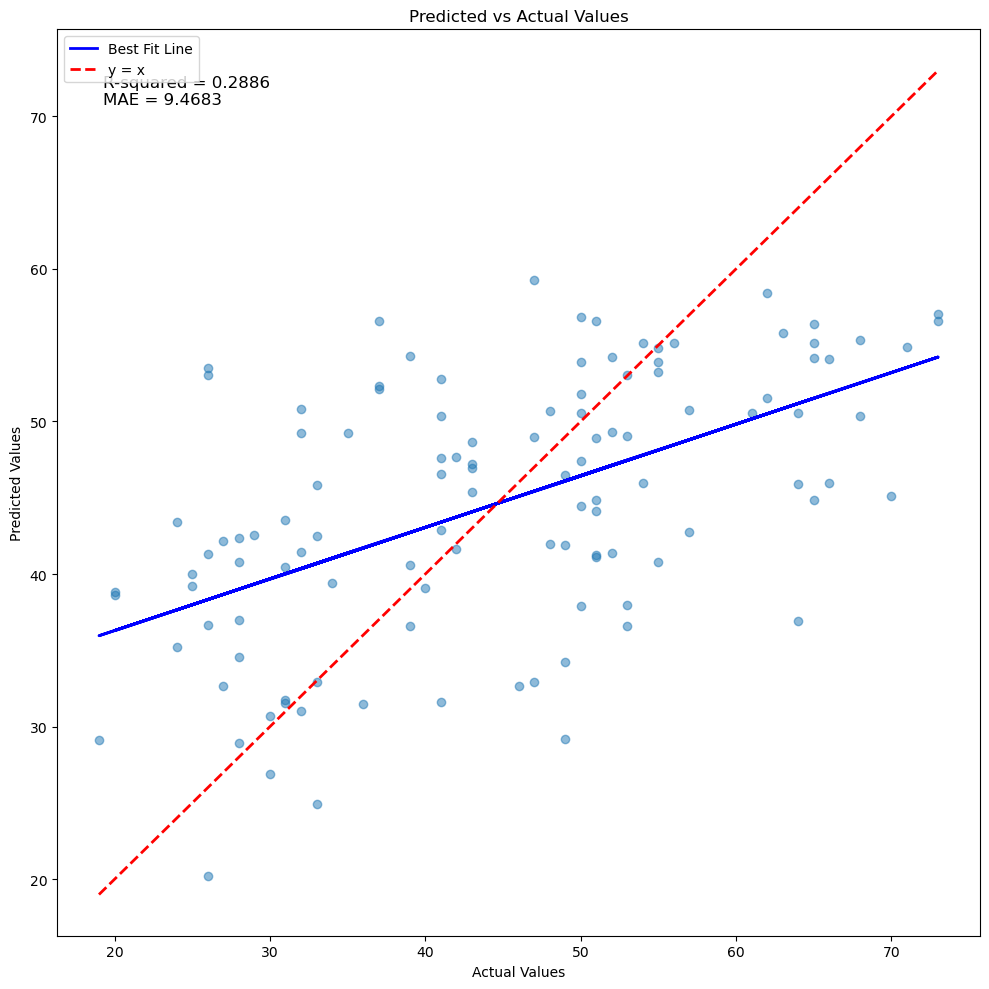

Final Test Loss: 9.4642


In [32]:
# Load the best regression model
regression_model.load_state_dict(torch.load('best_regression_model.pth'))

# Evaluate the model (you can add more evaluation metrics as needed)
regression_model.eval()
test_loss = utils.validate_regression(regression_model, test_loader, nn.L1Loss(), device, plot_reg=True)
print(f'Final Test Loss: {test_loss:.4f}')

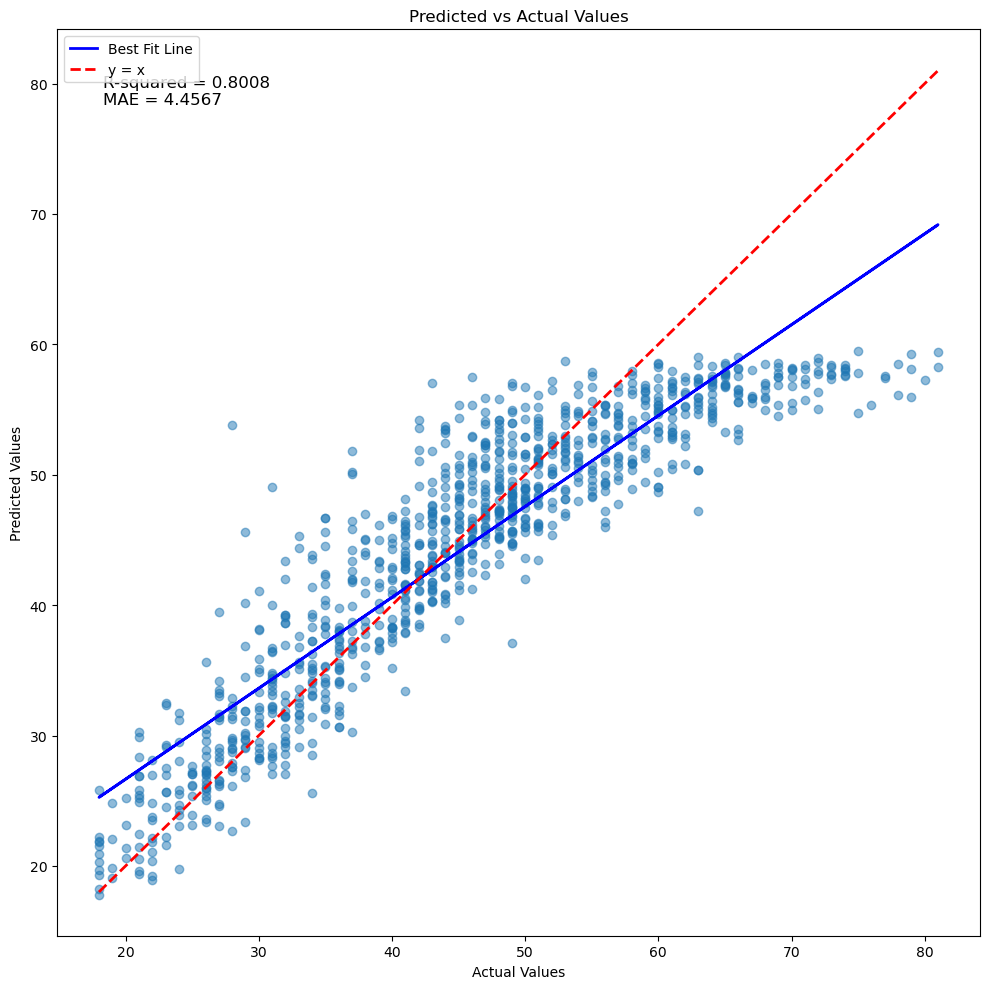

Final Test Loss: 4.4542


In [33]:
train_loss = utils.validate_regression(regression_model, train_loader, nn.L1Loss(), device, plot_reg=True)
print(f'Final Test Loss: {train_loss:.4f}')

#### Compare to RF regression

MAE: 10.9640350877193
R^2 Score: 0.14861065473530866


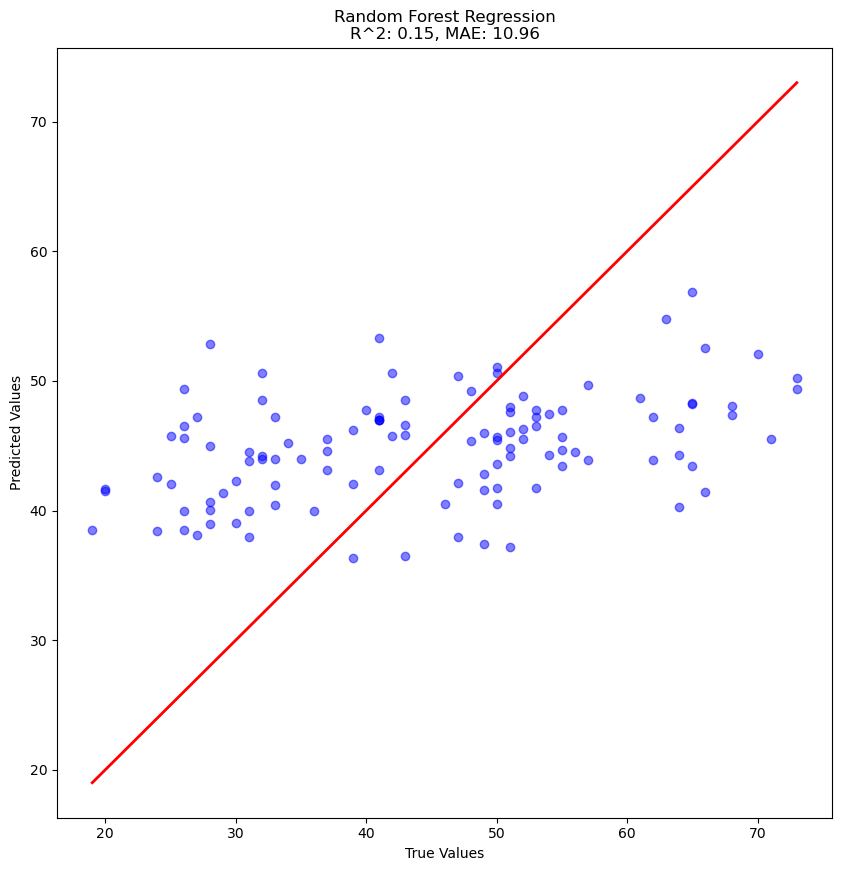

In [27]:
# Assuming your DataFrame is named df_regression
# X are the features and y is the target
X = df_regression.drop(columns=['regression_target'])
y = df_regression['regression_target']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=metadata.loc[df_regression.index].study_name)

# Step 3: Create and train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Step 4: Make predictions on the test set
y_pred = rf_regressor.predict(X_test)

# Step 5: Evaluate the model
mse = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MAE: {mse}')
print(f'R^2 Score: {r2}')

# Step 6: Plot the true vs predicted values for the test set
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2) # Line of perfect prediction
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title(f'Random Forest Regression\nR^2: {r2:.2f}, MAE: {mse:.2f}')
plt.show()

### Training Classification

In [38]:
# Main execution for classification fine-tuning
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained model (assuming MicrobiomeTransformer is defined elsewhere)
pretrained_model = MicrobiomeTransformer(vocab_size, d_model=2048, nhead=8, num_encoder_layers=1, taxa_to_idx=taxa_to_idx).to(device)
pretrained_model.load_state_dict(torch.load('best_model.pth'))


# Prepare data for classification
df_classification = np.log1p(raw_df.iloc[:,3:].fillna(0).copy())
df_classification = df_classification.loc[df_classification.index.isin(metadata.index)]
metadata['health_status'] = metadata['disease'].apply(lambda x: 'healthy' if x == 'healthy' else 'disease')
df_classification['classification_target'] = metadata.loc[df_classification.index, 'health_status']  # Change 'health_status' to your desired classification column
df_classification = df_classification.dropna()

# Create vocabulary
vocab = ['<PAD>', '<START>', '<END>'] + df_classification.drop(columns='classification_target').columns.tolist()
taxa_to_idx = {taxa: idx for idx, taxa in enumerate(vocab)}

# Prepare data
max_features = 128
dataset = utils.MicrobiomeClassificationDataset(df_classification, taxa_to_idx, 'classification_target', max_features=max_features)
train_data, test_data = train_test_split(dataset, test_size=0.1, random_state=42, stratify=metadata.loc[df_classification.index].health_status)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=utils.classification_collate_fn)
test_loader = DataLoader(test_data, batch_size=32, collate_fn=utils.classification_collate_fn)

# Create the classification model
num_classes = len(dataset.label_encoder.classes_)
classification_model = MicrobiomeTransformerClassification(pretrained_model, num_classes, freeze_pretrained=True).to(device)

# Train the classification model
utils.train_classification(classification_model, train_loader, test_loader, epochs=25, lr=0.000005, device=device)

/Users/tylermyers/anaconda3/envs/transformers/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1, Train Loss: 0.6206, Val Accuracy: 0.6956
Epoch 2, Train Loss: 0.6176, Val Accuracy: 0.6956
Epoch 3, Train Loss: 0.6155, Val Accuracy: 0.6956
Epoch 4, Train Loss: 0.6132, Val Accuracy: 0.6956
Epoch 5, Train Loss: 0.6095, Val Accuracy: 0.6956
Epoch 6, Train Loss: 0.6049, Val Accuracy: 0.7136
Epoch 7, Train Loss: 0.5988, Val Accuracy: 0.6966
Epoch 8, Train Loss: 0.5905, Val Accuracy: 0.6981
Epoch 9, Train Loss: 0.5835, Val Accuracy: 0.7136
Epoch 10, Train Loss: 0.5768, Val Accuracy: 0.7150
Epoch 11, Train Loss: 0.5993, Val Accuracy: 0.7199
Epoch 12, Train Loss: 0.5923, Val Accuracy: 0.7218
Epoch 13, Train Loss: 0.5908, Val Accuracy: 0.7209
Epoch 14, Train Loss: 0.5768, Val Accuracy: 0.7286
Epoch 15, Train Loss: 0.5686, Val Accuracy: 0.7209
Epoch 16, Train Loss: 0.5680, Val Accuracy: 0.7408
Epoch 17, Train Loss: 0.5623, Val Accuracy: 0.7117
Epoch 18, Train Loss: 0.5554, Val Accuracy: 0.6990
Epoch 19, Train Loss: 0.5482, Val Accuracy: 0.7427
Epoch 20, Train Loss: 0.5489, Val Accura

In [40]:
utils.train_classification(classification_model, train_loader, test_loader, epochs=50, lr=0.000005, device=device)

Epoch 1, Train Loss: 0.5613, Val Accuracy: 0.7024
Epoch 2, Train Loss: 0.5636, Val Accuracy: 0.7078
Epoch 3, Train Loss: 0.5531, Val Accuracy: 0.6966
Epoch 4, Train Loss: 0.5598, Val Accuracy: 0.7350
Epoch 5, Train Loss: 0.5389, Val Accuracy: 0.7296
Epoch 6, Train Loss: 0.5327, Val Accuracy: 0.7481
Epoch 7, Train Loss: 0.5322, Val Accuracy: 0.7500
Epoch 8, Train Loss: 0.5191, Val Accuracy: 0.7422
Epoch 9, Train Loss: 0.5090, Val Accuracy: 0.7374
Epoch 10, Train Loss: 0.5035, Val Accuracy: 0.7510
Epoch 11, Train Loss: 0.5653, Val Accuracy: 0.6029
Epoch 12, Train Loss: 0.5524, Val Accuracy: 0.7350
Epoch 13, Train Loss: 0.5525, Val Accuracy: 0.7447
Epoch 14, Train Loss: 0.5555, Val Accuracy: 0.7291
Epoch 15, Train Loss: 0.5504, Val Accuracy: 0.6985
Epoch 16, Train Loss: 0.5446, Val Accuracy: 0.6544
Epoch 17, Train Loss: 0.5423, Val Accuracy: 0.7451
Epoch 18, Train Loss: 0.5404, Val Accuracy: 0.7403
Epoch 19, Train Loss: 0.5351, Val Accuracy: 0.7466
Epoch 20, Train Loss: 0.5305, Val Accura

In [41]:
# Load the best regression model
classification_model.load_state_dict(torch.load('best_classification_model.pth'))

# Evaluate the model (you can add more evaluation metrics as needed)
classification_model.eval()
test_loss = utils.validate_classification(classification_model, test_loader, device, plot_conf_matrix=True)
print(f'Final Test Loss: {test_loss:.4f}')


Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.43      0.52       627
           1       0.78      0.90      0.84      1433

    accuracy                           0.76      2060
   macro avg       0.72      0.66      0.68      2060
weighted avg       0.74      0.76      0.74      2060

Final Test Loss: 0.7568
